<a href="https://colab.research.google.com/github/Viswesh934/3D-Segmentation/blob/main/5C_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import requests

# Define the URL of the file to download
url = "https://zenodo.org/records/7860267/files/FLARE22Train.zip?download=1"

# Define the destination where you want to save the file
destination = "FLARE22Train.zip"

# Download the file using requests
response = requests.get(url, stream=True)

# Save the file locally
with open(destination, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            file.write(chunk)

# Confirm the file has been downloaded
if os.path.exists(destination):
    print(f"File downloaded successfully and saved as {destination}")
else:
    print("File download failed")


File downloaded successfully and saved as FLARE22Train.zip


In [2]:
import zipfile

# Extract the contents of the ZIP file
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall("FLARE22Train")

print("File extracted successfully")

File extracted successfully


In [3]:
# List the contents of the extracted dataset folder
dataset_dir = "FLARE22Train"
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        print(os.path.join(root, file))

FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0005.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0025.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0043.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0044.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0032.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0011.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0013.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0024.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0021.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0009.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0015.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0028.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0040.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0012.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0035.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0046.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0002.nii.gz
FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0014

In [4]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Load a sample CT scan and its corresponding label (segmentation mask)
ct_scan_path = "/content/FLARE22Train/FLARE22Train/images/FLARE22_Tr_0001_0000.nii.gz"
label_path = "/content/FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0001.nii.gz"

# Load the CT scan and label (segmentation mask) using nibabel
ct_scan = nib.load(ct_scan_path)
ct_data = ct_scan.get_fdata()

label = nib.load(label_path)
label_data = label.get_fdata()

# Check the shape of the loaded data
print(f"CT Scan shape: {ct_data.shape}")
print(f"Label shape: {label_data.shape}")

CT Scan shape: (512, 512, 110)
Label shape: (512, 512, 110)


In [5]:
# Normalize the CT scan to have values between 0 and 1
ct_data_normalized = (ct_data - np.min(ct_data)) / (np.max(ct_data) - np.min(ct_data))

# Ensure the label data remains unchanged (as it represents categorical data)
label_data = label_data.astype(np.int32)

print(f"CT Scan after normalization: min {np.min(ct_data_normalized)}, max {np.max(ct_data_normalized)}")


CT Scan after normalization: min 0.0, max 1.0


In [6]:
from scipy.ndimage import zoom

# Desired output shape (example: 128x128x64)
output_shape = (128, 128, 64)

# Compute the zoom factors for each axis
zoom_factors = [o / i for o, i in zip(output_shape, ct_data.shape)]

# Resize the CT scan and label data
ct_data_resized = zoom(ct_data_normalized, zoom_factors, order=1)  # order=1 for linear interpolation
label_data_resized = zoom(label_data, zoom_factors, order=0)  # order=0 for nearest neighbor interpolation

print(f"Resized CT Scan shape: {ct_data_resized.shape}")
print(f"Resized Label shape: {label_data_resized.shape}")


Resized CT Scan shape: (128, 128, 64)
Resized Label shape: (128, 128, 64)


In [7]:
# Directory paths
ct_scan_dir = "/content/FLARE22Train/FLARE22Train/images"  # Directory containing CT scans
label_dir = "/content/FLARE22Train/FLARE22Train/labels"    # Directory containing labels

# List all CT scan and label files
ct_scan_list = sorted([os.path.join(ct_scan_dir, f) for f in os.listdir(ct_scan_dir) if f.endswith('.nii.gz')])
label_list = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.nii.gz')])

# Ensure that the lists match in length and corresponding files
assert len(ct_scan_list) == len(label_list), "Mismatch between number of CT scans and labels"
print(f"Number of CT scans: {len(ct_scan_list)}")
print(f"Number of labels: {len(label_list)}")


Number of CT scans: 50
Number of labels: 50


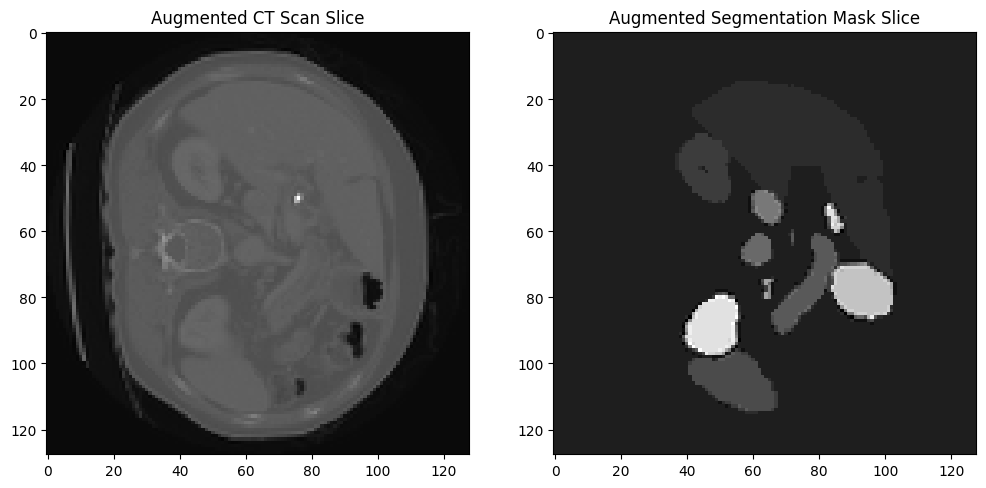

In [8]:
from scipy.ndimage import rotate

def augment_data(ct_scan, label, angle_range=30):
    # Randomly flip the images
    if np.random.rand() > 0.5:
        ct_scan = np.flip(ct_scan, axis=0)
        label = np.flip(label, axis=0)

    if np.random.rand() > 0.5:
        ct_scan = np.flip(ct_scan, axis=1)
        label = np.flip(label, axis=1)

    # Randomly rotate the images within the specified angle range
    angle = np.random.uniform(-angle_range, angle_range)
    ct_scan = rotate(ct_scan, angle, axes=(0, 1), reshape=False, mode='nearest')
    label = rotate(label, angle, axes=(0, 1), reshape=False, mode='nearest')

    return ct_scan, label

# Apply augmentation to a sample
aug_ct_scan, aug_label = augment_data(ct_data_resized, label_data_resized)

# Visualize the augmented slice
slice_num = aug_ct_scan.shape[2] // 2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(aug_ct_scan[:, :, slice_num], cmap="gray")
plt.title("Augmented CT Scan Slice")
plt.subplot(1, 2, 2)
plt.imshow(aug_label[:, :, slice_num], cmap="gray")
plt.title("Augmented Segmentation Mask Slice")
plt.show()


In [9]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (e.g., 80% train, 20% validation)
train_ct, val_ct, train_label, val_label = train_test_split(ct_scan_list, label_list, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_ct)}")
print(f"Validation set size: {len(val_ct)}")

Training set size: 40
Validation set size: 10


Number of CT scans: 50
Number of labels: 50
Training set size: 40
Validation set size: 10
Number of classes in the dataset: 14
Number of classes detected: 14
Number of classes detected: 14
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.8270 - loss: 1.6454 - val_accuracy: 0.9328 - val_loss: 0.2647
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.9308 - loss: 0.2824 - val_accuracy: 0.9328 - val_loss: 0.2479
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.9262 - loss: 0.2750 - val_accuracy: 0.9328 - val_loss: 0.2492
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.9271 - loss: 0.2717 - val_accuracy: 0.9328 - val_loss: 0.2473
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.9290 - loss: 0.2661 - val_accuracy: 0.9328 - val_loss: 0.2393
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.9293 - loss: 0.2490 - val_accuracy: 0.9328 - val_loss: 0.2393
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.9265 - loss: 0.2523 - val_accuracy: 0.9328 - val_loss: 0.2178
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.9275 - loss: 0.2395 - val_accuracy: 0.9328 - val_loss: 0.

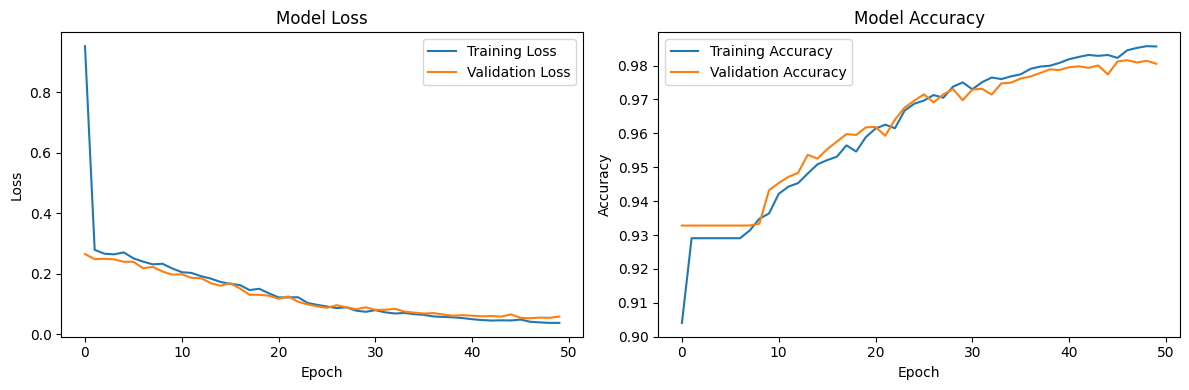

Model saved as 'final_model.keras'


In [10]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import nibabel as nib
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Define the 3D U-Net model
def create_3d_unet(input_shape=(128, 128, 64, 1), num_classes=2):
    inputs = layers.Input(input_shape)

    # Encoder (downsampling)
    conv1 = layers.Conv3D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv3D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv1)

    conv2 = layers.Conv3D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv3D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling3D(pool_size=(2, 2, 2))(conv2)

    # Bridge
    conv3 = layers.Conv3D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv3D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder (upsampling)
    up4 = layers.UpSampling3D(size=(2, 2, 2))(conv3)
    up4 = layers.concatenate([up4, conv2])
    conv4 = layers.Conv3D(128, 3, activation='relu', padding='same')(up4)
    conv4 = layers.Conv3D(128, 3, activation='relu', padding='same')(conv4)

    up5 = layers.UpSampling3D(size=(2, 2, 2))(conv4)
    up5 = layers.concatenate([up5, conv1])
    conv5 = layers.Conv3D(64, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv3D(64, 3, activation='relu', padding='same')(conv5)

    outputs = layers.Conv3D(num_classes, 1, activation='softmax')(conv5)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Create data generator
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, ct_files, label_files, batch_size=1, dim=(128, 128, 64), n_channels=1, n_classes=None, shuffle=True):
        self.ct_files = ct_files
        self.label_files = label_files
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

        # Determine the number of classes from the data
        sample_label = nib.load(label_files[0]).get_fdata()
        self.n_classes = len(np.unique(sample_label))
        print(f"Number of classes detected: {self.n_classes}")

    def __len__(self):
        return int(np.floor(len(self.ct_files) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        ct_files_temp = [self.ct_files[k] for k in indexes]
        label_files_temp = [self.label_files[k] for k in indexes]
        X, y = self.__data_generation(ct_files_temp, label_files_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ct_files))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, ct_files_temp, label_files_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_classes))

        for i, (ct_file, label_file) in enumerate(zip(ct_files_temp, label_files_temp)):
            ct_data = nib.load(ct_file).get_fdata()
            label_data = nib.load(label_file).get_fdata()

            ct_data_normalized = (ct_data - np.min(ct_data)) / (np.max(ct_data) - np.min(ct_data))
            ct_data_resized = zoom(ct_data_normalized, [o / i for o, i in zip(self.dim, ct_data.shape)], order=1)
            label_data_resized = zoom(label_data, [o / i for o, i in zip(self.dim, label_data.shape)], order=0)

            X[i,] = np.expand_dims(ct_data_resized, axis=-1)
            y[i,] = tf.keras.utils.to_categorical(label_data_resized, num_classes=self.n_classes)

        return X, y

# Main execution
if __name__ == "__main__":
    # Directory paths
    ct_scan_dir = "/content/FLARE22Train/FLARE22Train/images"
    label_dir = "/content/FLARE22Train/FLARE22Train/labels"

    # List all CT scan and label files
    ct_scan_list = sorted([os.path.join(ct_scan_dir, f) for f in os.listdir(ct_scan_dir) if f.endswith('.nii.gz')])
    label_list = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.nii.gz')])

    # Ensure that the lists match in length and corresponding files
    assert len(ct_scan_list) == len(label_list), "Mismatch between number of CT scans and labels"
    print(f"Number of CT scans: {len(ct_scan_list)}")
    print(f"Number of labels: {len(label_list)}")

    # Split the data into training and validation sets
    train_ct, val_ct, train_label, val_label = train_test_split(ct_scan_list, label_list, test_size=0.2, random_state=42)

    print(f"Training set size: {len(train_ct)}")
    print(f"Validation set size: {len(val_ct)}")

    # Determine the number of classes from the data
    sample_label = nib.load(train_label[0]).get_fdata()
    num_classes = len(np.unique(sample_label))
    print(f"Number of classes in the dataset: {num_classes}")

    # Set up training
    model = create_3d_unet(input_shape=(128, 128, 64, 1), num_classes=num_classes)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    train_generator = DataGenerator(train_ct, train_label, n_classes=num_classes)
    val_generator = DataGenerator(val_ct, val_label, n_classes=num_classes)

    # Train the model
    history = model.fit(train_generator, validation_data=val_generator, epochs=50, callbacks=[
        tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True),
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ])

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(val_generator)
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Save the model
    model.save('final_model.keras')
    print("Model saved as 'final_model.keras'")

In [15]:
def evaluate_model(generator, model):
    dice_scores = {i: [] for i in range(generator.n_classes)}

    for i in range(len(generator)):
        X, y_true = generator[i]  # y_true shape is (batch_size, 128, 128, 64, num_classes)
        y_pred = model.predict(X)  # y_pred shape should be similar to (batch_size, 128, 128, 64, num_classes)

        # Convert predicted probabilities to class labels
        y_pred_classes = np.argmax(y_pred, axis=-1)  # shape: (batch_size, 128, 128, 64)

        # Ensure the shape of y_pred_classes matches the shape of y_true (without the one-hot dimension)
        y_true_classes = np.argmax(y_true, axis=-1)  # shape: (batch_size, 128, 128, 64)

        # Calculate Dice score for each class
        for class_index in range(generator.n_classes):
            y_true_class = (y_true_classes == class_index).astype(np.float32)
            y_pred_class = (y_pred_classes == class_index).astype(np.float32)
            dice = dice_score(y_true_class, y_pred_class)
            dice_scores[class_index].append(dice)

    # Report the average Dice score for each class
    for class_index in range(generator.n_classes):
        print(f"Dice Score for class {class_index}: {np.mean(dice_scores[class_index]):.4f}")

    return dice_scores


In [16]:
dice_scores = evaluate_model(val_generator, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Dice Score for class 0: 0.9913
Dice Score for class 1: 0.9176
Dice Score for class 2: 0.8903
Dice Score for class 3: 0.8460
Dice Score for class 4: 0.2264
Dice Score for class 5: 0.7696
Dice Score for class 6: 0.6484
Dice Score for class 7: 0.0139
Dice Score for class 8: 0.0000
Dice Score for class 9: 0.3467
Dice Score for class 10: 0.4352
Dice Score for class 11: 0.6701
Dice Score for class 12: 0.1689
Dice Score for class 13: 0.8576


In [20]:
import nibabel as nib
import numpy as np
import os
from scipy.ndimage import zoom

def predict_and_visualize(model, ct_scan_file, label_file, output_dir):
    # Load the new CT scan and corresponding labels
    ct_scan = nib.load(ct_scan_file)
    ct_scan_data = ct_scan.get_fdata()  # This returns the data as a numpy array
    label_data = nib.load(label_file).get_fdata()

    # Normalize the CT scan data if necessary (assuming the model expects normalized data)
    ct_scan_data = (ct_scan_data - np.mean(ct_scan_data)) / np.std(ct_scan_data)

    # Resample the CT scan data to match the expected input shape of the model
    desired_shape = (128,128,64)  # Adjust based on the model's expected input shape
    current_shape = ct_scan_data.shape

    # Calculate the zoom factor for each dimension
    zoom_factors = [desired / current for desired, current in zip(desired_shape, current_shape)]
    ct_scan_data_resampled = zoom(ct_scan_data, zoom_factors, order=1)  # order=1 for bilinear interpolation

    # Predict the segmentation
    y_pred = model.predict(ct_scan_data_resampled[None, ..., None])  # Assuming the model expects shape (1, x, y, z, 1)
    y_pred_classes = np.argmax(y_pred, axis=-1).squeeze()

    # Convert the prediction and label data to a compatible type, e.g., int16
    y_pred_classes = y_pred_classes.astype(np.int16)
    label_data = label_data.astype(np.int16)

    # Create NIfTI images for visualization
    pred_img = nib.Nifti1Image(y_pred_classes, ct_scan.affine, ct_scan.header)
    label_img = nib.Nifti1Image(label_data, ct_scan.affine, ct_scan.header)

    # Save the images
    pred_file = os.path.join(output_dir, 'prediction.nii.gz')
    label_file = os.path.join(output_dir, 'label.nii.gz')

    nib.save(pred_img, pred_file)
    nib.save(label_img, label_file)

    print(f"Prediction and label images saved to {output_dir}")

# Example usage on new data
new_ct_scan_file = "/content/FLARE22Train/FLARE22Train/images/FLARE22_Tr_0050_0000.nii.gz"
new_label_file = "/content/FLARE22Train/FLARE22Train/labels/FLARE22_Tr_0050.nii.gz"
output_dir = "/content/FLARE22Train"

predict_and_visualize(model, new_ct_scan_file, new_label_file, output_dir)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Prediction and label images saved to /content/FLARE22Train


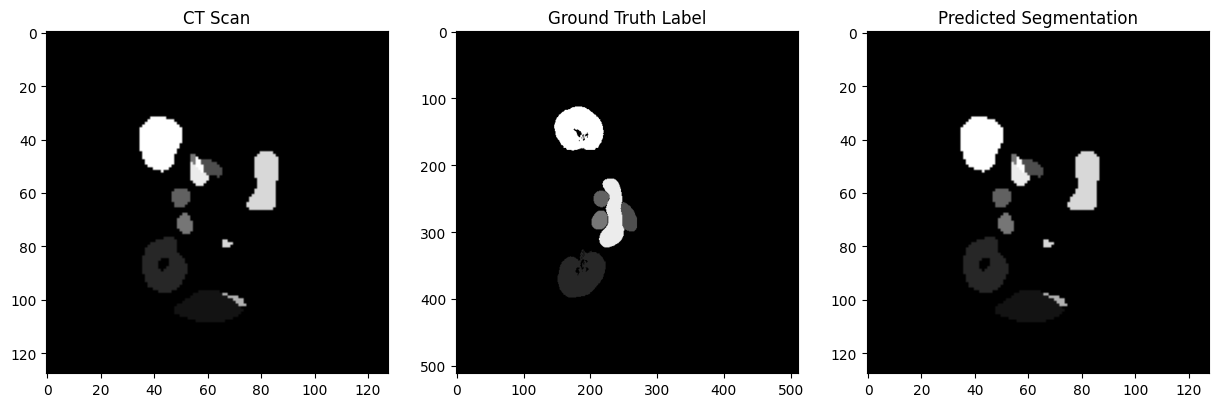

In [21]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def visualize_slices(ct_scan_file, label_file, pred_file, slice_index):
    # Load the images
    ct_scan = nib.load(ct_scan_file).get_fdata()
    label = nib.load(label_file).get_fdata()
    pred = nib.load(pred_file).get_fdata()

    # Plot the specific slice
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("CT Scan")
    plt.imshow(ct_scan[:, :, slice_index], cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Label")
    plt.imshow(label[:, :, slice_index], cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Segmentation")
    plt.imshow(pred[:, :, slice_index], cmap="gray")

    plt.show()

# Example usage
ct_scan_file = "/content/FLARE22Train/prediction.nii.gz"
label_file = "/content/FLARE22Train/label.nii.gz"
pred_file = "/content/FLARE22Train/prediction.nii.gz"

# Visualize the middle slice (adjust index based on your data)
slice_index = 30  # Change based on your dataset's dimensions
visualize_slices(ct_scan_file, label_file, pred_file, slice_index)


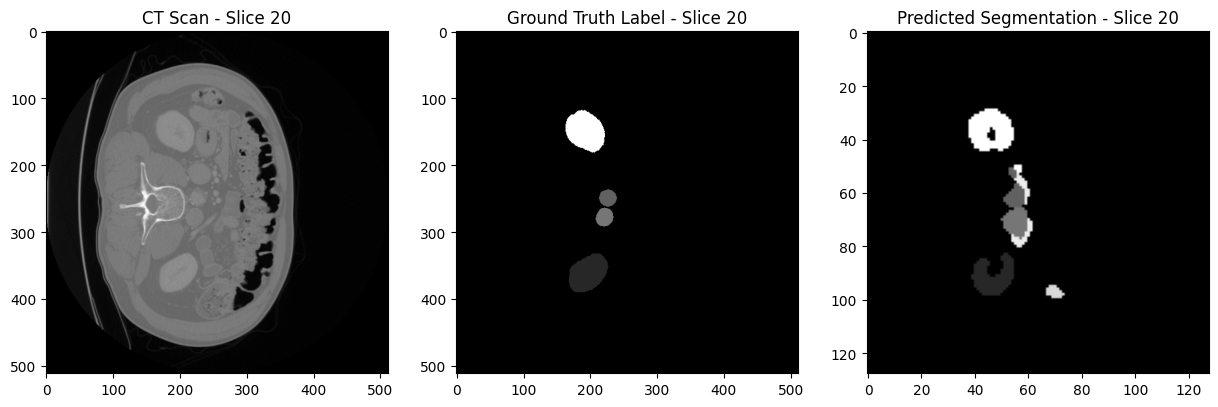

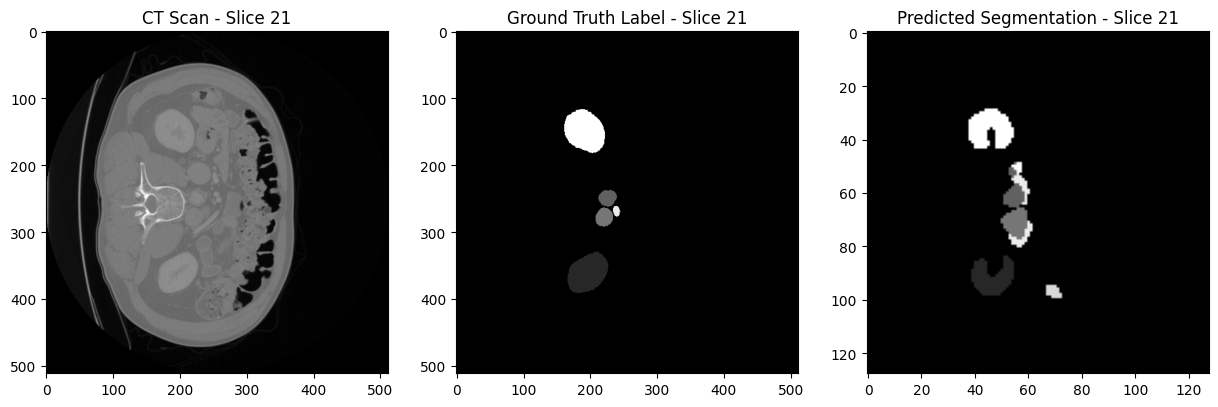

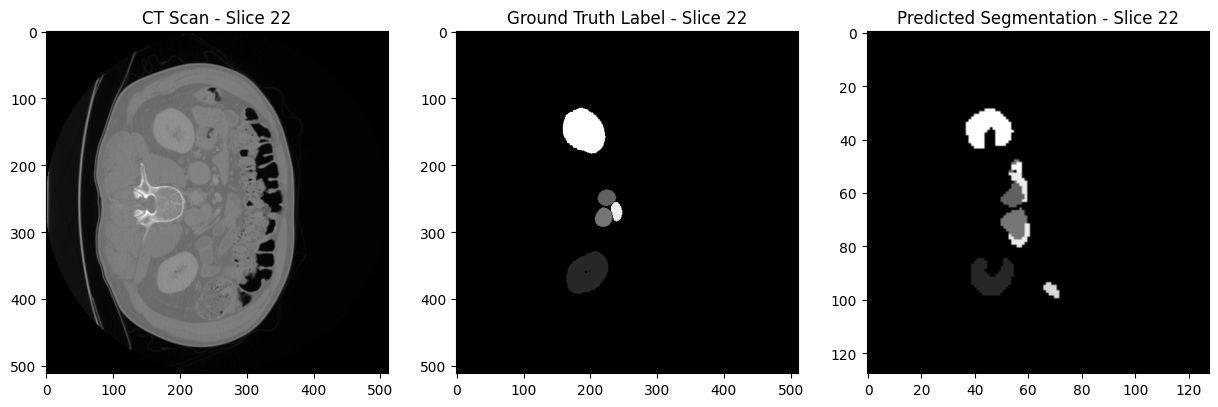

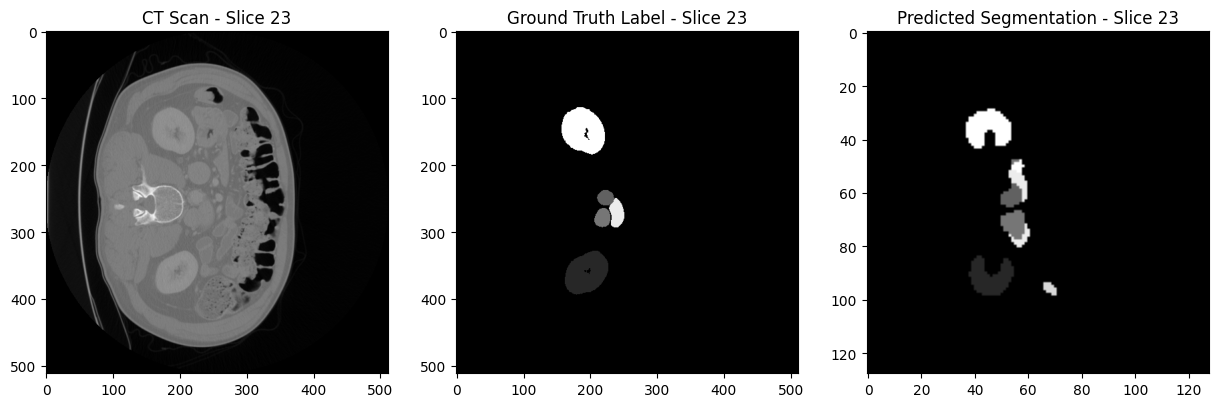

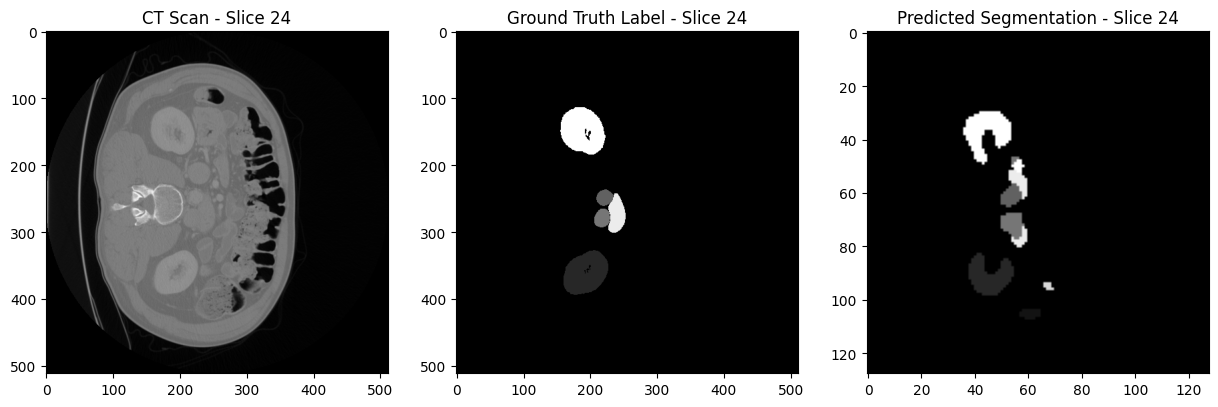

In [24]:
def visualize_multiple_slices(ct_scan_file, label_file, pred_file, start_slice, end_slice):
    # Load the images
    ct_scan = nib.load(ct_scan_file).get_fdata()
    label = nib.load(label_file).get_fdata()
    pred = nib.load(pred_file).get_fdata()

    for i in range(start_slice, end_slice):
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.title(f"CT Scan - Slice {i}")
        plt.imshow(ct_scan[:, :, i], cmap="gray")

        plt.subplot(1, 3, 2)
        plt.title(f"Ground Truth Label - Slice {i}")
        plt.imshow(label[:, :, i], cmap="gray")

        plt.subplot(1, 3, 3)
        plt.title(f"Predicted Segmentation - Slice {i}")
        plt.imshow(pred[:, :, i], cmap="gray")

        plt.show()

# Example usage
start_slice = 20  # Start from slice 20
end_slice = 25    # End at slice 25
visualize_multiple_slices(ct_scan_file, label_file, pred_file, start_slice, end_slice)


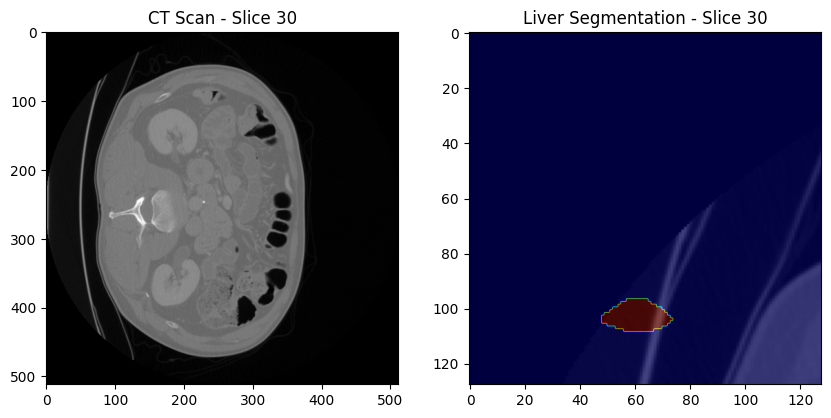

In [23]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Example mapping of labels to organs (adjust according to your dataset)
label_to_organ = {
    1: "Liver",
    2: "Kidney",
    3: "Spleen",
    4: "Pancreas",

}

def visualize_organ(ct_scan_file, pred_file, organ_label, slice_index):
    # Load the CT scan and predicted segmentation
    ct_scan = nib.load(ct_scan_file).get_fdata()
    pred = nib.load(pred_file).get_fdata()

    # Create a binary mask for the specified organ
    organ_mask = np.where(pred == organ_label, 1, 0)

    plt.figure(figsize=(10, 5))

    # Display the CT scan slice
    plt.subplot(1, 2, 1)
    plt.title(f"CT Scan - Slice {slice_index}")
    plt.imshow(ct_scan[:, :, slice_index], cmap="gray")

    # Overlay the organ mask on the CT scan
    plt.subplot(1, 2, 2)
    plt.title(f"{label_to_organ[organ_label]} Segmentation - Slice {slice_index}")
    plt.imshow(ct_scan[:, :, slice_index], cmap="gray")
    plt.imshow(organ_mask[:, :, slice_index], cmap="jet", alpha=0.5)  # Overlay with transparency

    plt.show()

# Example usage
ct_scan_file = "/content/FLARE22Train/FLARE22Train/images/FLARE22_Tr_0050_0000.nii.gz"
pred_file = "/content/FLARE22Train/prediction.nii.gz"

# Specify the organ label and slice index to visualize
organ_label = 1  # Change this to the label corresponding to the organ you want to visualize
slice_index = 30  # Adjust based on your dataset's dimensions

visualize_organ(ct_scan_file, pred_file, organ_label, slice_index)


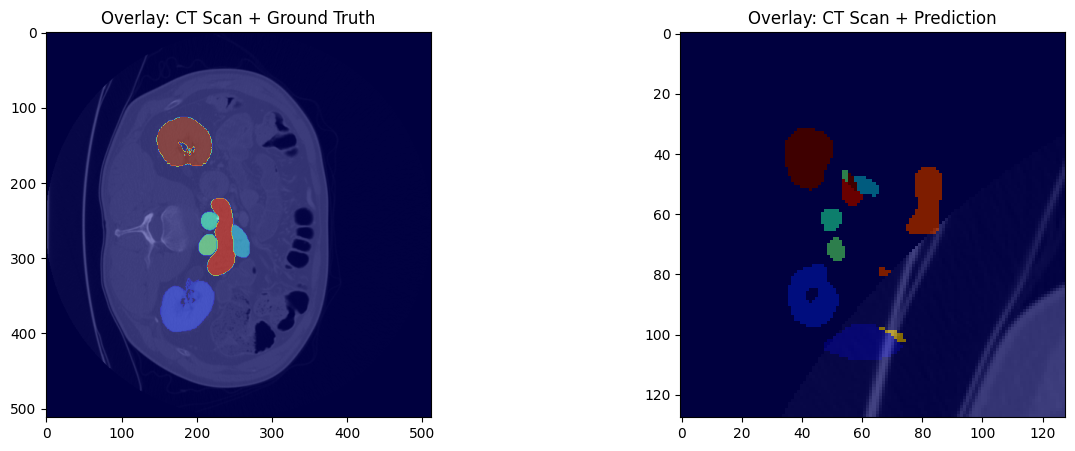

In [25]:
def visualize_overlay(ct_scan_file, label_file, pred_file, slice_index):
    # Load the images
    ct_scan = nib.load(ct_scan_file).get_fdata()
    label = nib.load(label_file).get_fdata()
    pred = nib.load(pred_file).get_fdata()

    plt.figure(figsize=(15, 5))

    # Overlay the prediction on the CT scan
    plt.subplot(1, 2, 1)
    plt.title("Overlay: CT Scan + Ground Truth")
    plt.imshow(ct_scan[:, :, slice_index], cmap="gray")
    plt.imshow(label[:, :, slice_index], cmap="jet", alpha=0.5)  # Overlay with transparency

    plt.subplot(1, 2, 2)
    plt.title("Overlay: CT Scan + Prediction")
    plt.imshow(ct_scan[:, :, slice_index], cmap="gray")
    plt.imshow(pred[:, :, slice_index], cmap="jet", alpha=0.5)  # Overlay with transparency

    plt.show()

# Example usage
slice_index = 30  # Change based on your dataset's dimensions
visualize_overlay(ct_scan_file, label_file, pred_file, slice_index)


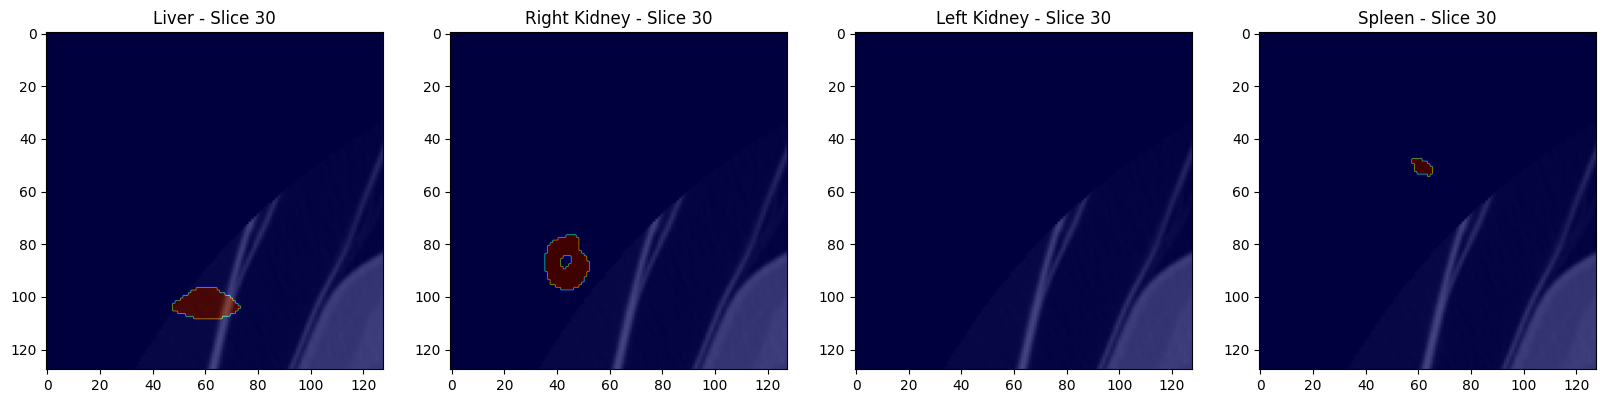

In [29]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Mapping of class IDs to organs
label_to_organ = {
    1: "Liver",
    2: "Right Kidney",
    3: "Left Kidney",
    4: "Spleen"
}

def visualize_organs(ct_scan_file, pred_file, organ_labels, slice_index):
    # Load the CT scan and predicted segmentation
    ct_scan = nib.load(ct_scan_file).get_fdata()
    pred = nib.load(pred_file).get_fdata()

    plt.figure(figsize=(20, 10))

    for i, organ_label in enumerate(organ_labels):
        # Create a binary mask for the specified organ
        organ_mask = np.where(pred == organ_label, 1, 0)

        plt.subplot(1, len(organ_labels), i+1)
        plt.title(f"{label_to_organ[organ_label]} - Slice {slice_index}")
        plt.imshow(ct_scan[:, :, slice_index], cmap="gray")
        plt.imshow(organ_mask[:, :, slice_index], cmap="jet", alpha=0.5)  # Overlay with transparency

    plt.show()

# Example usage
ct_scan_file = "/content/FLARE22Train/FLARE22Train/images/FLARE22_Tr_0050_0000.nii.gz"
pred_file = "/content/FLARE22Train/prediction.nii.gz"

# Specify the organ labels and slice index to visualize
organ_labels = [1, 2, 3, 4]  # Liver, Right Kidney, Left Kidney, Spleen
slice_index = 30  # Adjust based on your dataset's dimensions

visualize_organs(ct_scan_file, pred_file, organ_labels, slice_index)
